# HackLive - Guided Community Hackathon III - NLP
# Topic Modeling for Research Articles 2.0

[Link to competition here!](https://datahack.analyticsvidhya.com/contest/hacklive-3-guided-hackathon-text-classification/)

Go there and register to be able to download the dataset and submit your predictions. Click the button below to open this notebook in Google Colab!

<a href="https://colab.research.google.com/github/jpraguer/jpraguer.github.io/master/_posts/NLPEDABaseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Researchers have access to large online archives of scientific articles. As a consequence, finding relevant articles has become more and more difficult. Tagging or topic modelling provides a way to give clear token of identification to research articles which facilitates recommendation and search process. 

Earlier on the Independence Day we conducted a Hackathon to predict the topics for each article included in the test set. Continuing with the same problem, In this Live Hackathon we will take one more step ahead and predict the tags associated with the articles.

Given the abstracts for a set of research articles, predict the tags for each article included in the test set. 
Note that a research article can possibly have multiple tags. The research article abstracts are sourced from the following 4 topics: 

1. Computer Science

2. Mathematics

3. Physics

4. Statistics

List of 25 possible tags are as follows:

[Tags, Analysis of PDEs, Applications, Artificial Intelligence,Astrophysics of Galaxies, Computation and Language, Computer Vision and Pattern Recognition, Cosmology and Nongalactic Astrophysics, Data Structures and Algorithms, Differential Geometry, Earth and Planetary Astrophysics, Fluid Dynamics,Information Theory, Instrumentation and Methods for Astrophysics, Machine Learning, Materials Science, Methodology, Number Theory, Optimization and Control, Representation Theory, Robotics, Social and Information Networks, Statistics Theory, Strongly Correlated Electrons, Superconductivity, Systems and Control]

### Multi Class vs Multi Label Classification
* **Multi Class** - There are multiple categories but each instance is assigned only one, therefore such problems are known as multi-class classification problem.
* **Multi Label** - There are multiple categories and each instance can be assigned with multiple categories, so these types of problems are known as multi-label classification problem, where we have a set of target labels.

This problem is a *multi label* classification problem, as each study can have multiple tags. This makes this competition possibly easier, as we can train separate classifier models for each target column.

In [1]:
# import libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score

In [2]:
# load data and set seed
BASE = 'https://drive.google.com/uc?export=download&id='
SEED = 2021

train = pd.read_csv(f'{BASE}1ung4VaqpYSJNnTuGTyGChLT8C0eNYY5N')
test = pd.read_csv(f'{BASE}1HwI9Y21-iaCzcaYZI_2J7hirFceZ-phz')
ss = pd.read_csv(f'{BASE}1vas9LzJlJiXQG-Z_252gIgKtzJq9I3iW')

In [3]:
# prepare a few key variables to classify columns into target and features
# strangely we have more targets than features in this competition
ID_COL = 'id'

TARGET_COLS = ['Analysis of PDEs', 'Applications',
               'Artificial Intelligence', 'Astrophysics of Galaxies',
               'Computation and Language', 'Computer Vision and Pattern Recognition',
               'Cosmology and Nongalactic Astrophysics',
               'Data Structures and Algorithms', 'Differential Geometry',
               'Earth and Planetary Astrophysics', 'Fluid Dynamics',
               'Information Theory', 'Instrumentation and Methods for Astrophysics',
               'Machine Learning', 'Materials Science', 'Methodology', 'Number Theory',
               'Optimization and Control', 'Representation Theory', 'Robotics',
               'Social and Information Networks', 'Statistics Theory',
               'Strongly Correlated Electrons', 'Superconductivity',
               'Systems and Control'] #class_names

TOPIC_COLS = ['Computer Science', 'Mathematics', 'Physics', 'Statistics']

## EDA starts
First we look at the first few rows of the train dataset.

In [4]:
train.head(3)

,id,ABSTRACT,Computer Science,Mathematics,Physics,Statistics,Analysis of PDEs,Applications,Artificial Intelligence,Astrophysics of Galaxies,Computation and Language,Computer Vision and Pattern Recognition,Cosmology and Nongalactic Astrophysics,Data Structures and Algorithms,Differential Geometry,Earth and Planetary Astrophysics,Fluid Dynamics,Information Theory,Instrumentation and Methods for Astrophysics,Machine Learning,Materials Science,Methodology,Number Theory,Optimization and Control,Representation Theory,Robotics,Social and Information Networks,Statistics Theory,Strongly Correlated Electrons,Superconductivity,Systems and Control
0,1824,a ever-growing datasets inside observational a...,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,3094,we propose the framework considering optimal $...,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,8463,nanostructures with open shell transition meta...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [5]:
# look at train and test sizes
train.shape, test.shape

((14004, 31), (6002, 6))

In [6]:
# check for nulls and parsing errors
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14004 entries, 0 to 14003
Data columns (total 31 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   id                                            14004 non-null  int64 
 1   ABSTRACT                                      14004 non-null  object
 2   Computer Science                              14004 non-null  int64 
 3   Mathematics                                   14004 non-null  int64 
 4   Physics                                       14004 non-null  int64 
 5   Statistics                                    14004 non-null  int64 
 6   Analysis of PDEs                              14004 non-null  int64 
 7   Applications                                  14004 non-null  int64 
 8   Artificial Intelligence                       14004 non-null  int64 
 9   Astrophysics of Galaxies                      14004 non-null  int64 
 10

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6002 entries, 0 to 6001
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                6002 non-null   int64 
 1   ABSTRACT          6002 non-null   object
 2   Computer Science  6002 non-null   int64 
 3   Mathematics       6002 non-null   int64 
 4   Physics           6002 non-null   int64 
 5   Statistics        6002 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 281.5+ KB


No nulls, parsing algorithm did well, no abstracts seem to have been truncated.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


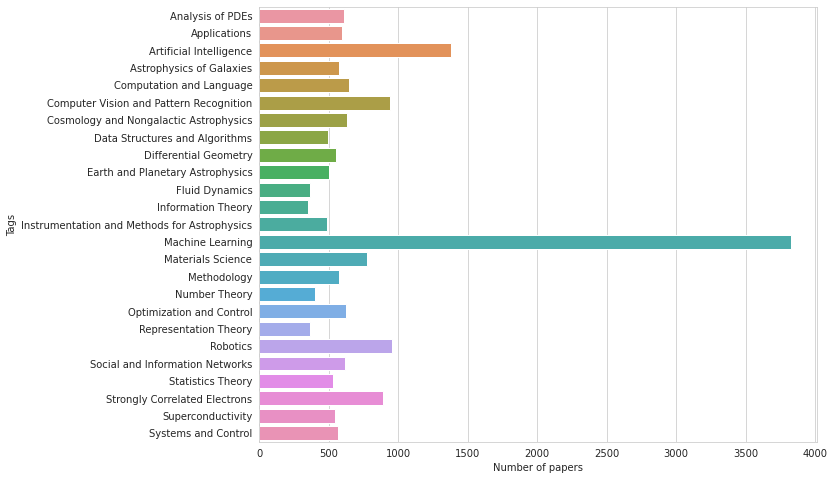

In [8]:
# count of papers for each tag and topic in TRAIN
plt.figure(figsize=(10, 8))
sns.barplot(train[TARGET_COLS].sum().values, TARGET_COLS)
plt.xlabel('Number of papers')
plt.ylabel('Tags');

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


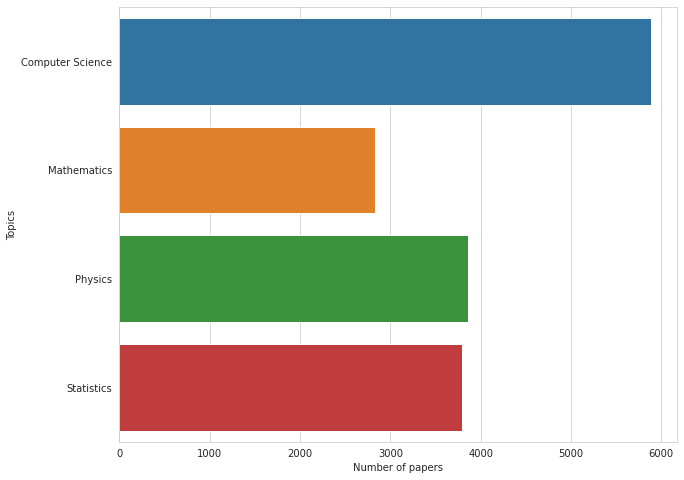

In [9]:
# count of papers for each tag and topic in TRAIN
plt.figure(figsize=(10, 8))
sns.barplot(train[TOPIC_COLS].sum().values, TOPIC_COLS)
plt.xlabel('Number of papers')
plt.ylabel('Topics');

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


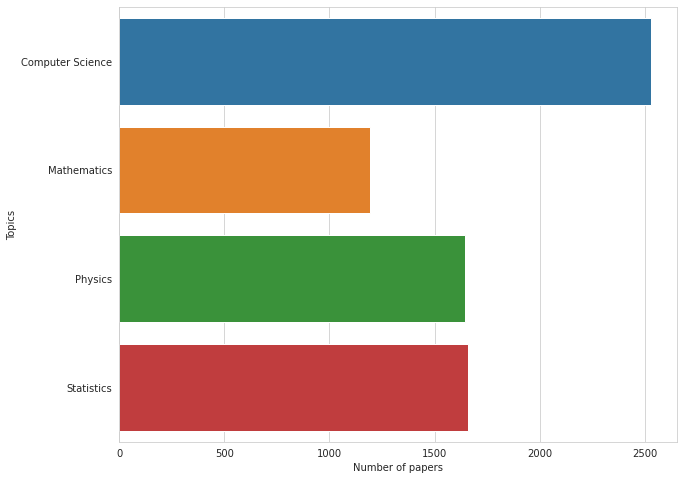

In [10]:
# count of papers in each topic in TEST 
# seems to be distributed similarly to TRAIN
plt.figure(figsize=(10, 8))
sns.barplot(test[TOPIC_COLS].sum().values, TOPIC_COLS)
plt.xlabel('Number of papers')
plt.ylabel('Topics');

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


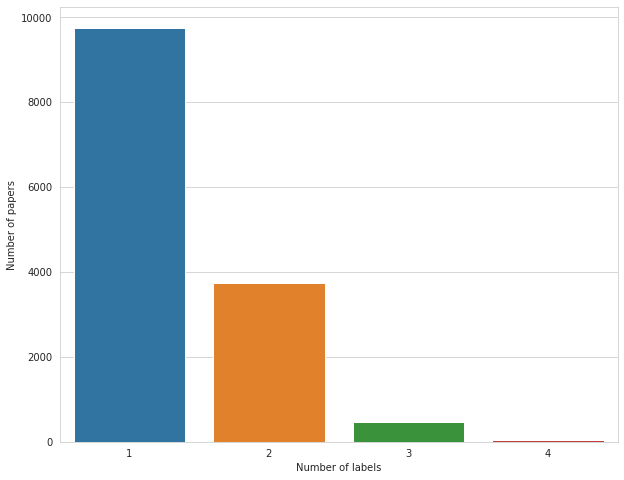

In [11]:
# count of papers having multiple labels
multilabel_counts = train[TARGET_COLS].sum(axis=1).value_counts()

plt.figure(figsize=(10, 8))
sns.barplot(multilabel_counts.index, multilabel_counts.values)
plt.ylabel('Number of papers')
plt.xlabel('Number of labels')
plt.show()

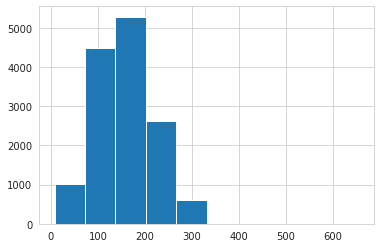

In [12]:
# word lengths histogram => looks like ~320 words is maximum length
train['ABSTRACT'].str.split().apply(len).hist();

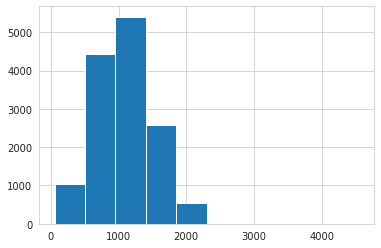

In [13]:
# char lengths histogram => looks like ~2200 chars is maximum length
train['ABSTRACT'].str.len().hist();

#### Observations
Most papers have ML, followed by AI tags (perhaps not surprising in an ML competition). Most common topics are CompSci and Physics or Statistics.
Majority of papers have only one tag, but there are a few that have as many as four. Abstracts seem to be at most 320 words and 2200 chars in length (this will come in handy later). 

## Text processing and Modeling
Now we will perform train test split, clean the text and train a Logistic Regression model based on TF-IDF features transformed using a Naive Bayes algorithm.

In [14]:
# train test split, shuffle and stratify based on topics
trn, val = train_test_split(train, test_size=0.2, random_state=SEED, shuffle=True, stratify=train[TOPIC_COLS])

In [16]:
# clean text function declaration
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\t', ' ', text)
    text = text.strip(' ')
    return text

In [17]:
%%time
# clean the abstract in train, val and test sets
trn_text = trn['ABSTRACT'].apply(clean_text)
val_text = val['ABSTRACT'].apply(clean_text)
test_text = test['ABSTRACT'].apply(clean_text)
all_text = pd.concat([trn_text, val_text, test_text])

CPU times: user 2.37 s, sys: 4.86 ms, total: 2.37 s
Wall time: 2.38 s


In [15]:
# create a custom string tokenizer with extra punctuation
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [18]:
%%time
# create and use a TF-IDF vectorizer on word level using our tokenizer defined above
# docs: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,        # optional
    strip_accents='unicode',  # further character normalisation
    analyzer='word',          # use word n-grams
    tokenizer=tokenize,       # use custom tokenizer
    stop_words='english',     # remove english stopwords
    ngram_range=(1,2),        # use unigrams and bigrams
    max_features=20000)       # only top 20k unique n-grams for speed
print("fitting...")
word_vectorizer.fit(all_text)
print("train...")
train_word_features = word_vectorizer.transform(trn_text)
print("val...")
val_word_features = word_vectorizer.transform(val_text)
print("test...")
test_word_features = word_vectorizer.transform(test_text)

fitting...


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


train...
val...
test...
CPU times: user 19.3 s, sys: 941 ms, total: 20.3 s
Wall time: 20.9 s


In [19]:
%%time
# create and use a TF-IDF vectorizer on char level
# docs linked above
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,        # optional
    strip_accents='unicode',  # further character normalisation
    analyzer='char',          # use char n-grams
    ngram_range=(2,6),        # use bigrams up to hexagrams
    max_features=50000)       # only top 50k unique n-grams (still quite slow)
print("fitting...")
char_vectorizer.fit(all_text)
print("train...")
train_char_features = char_vectorizer.transform(trn_text)
print("val...")
val_char_features = char_vectorizer.transform(val_text)
print("test...")
test_char_features = char_vectorizer.transform(test_text)

fitting...
train...
val...
test...
CPU times: user 3min 2s, sys: 3.1 s, total: 3min 5s
Wall time: 3min 5s


In [20]:
%%time
# stack topics, char and word features horizontally to get a numpy matrix
x = hstack([trn[TOPIC_COLS], train_char_features, train_word_features], format='csr')
val_x = hstack([val[TOPIC_COLS], val_char_features, val_word_features], format='csr')
test_x = hstack([test[TOPIC_COLS], test_char_features, test_word_features], format='csr')

CPU times: user 5.03 s, sys: 150 ms, total: 5.18 s
Wall time: 5.17 s


In [21]:
# basic naive bayes feature equation
# credit: Jeremy Howard (kaggle and fast.ai legend)
# https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [22]:
# fit a model for one dependent at a time
def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=4,                # less regularization, tunable hyperparam
                           dual=True,          # imperative for one vs many classification
                           solver='liblinear') # good for one vs many classification
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

In [23]:
%%time
# create empty arrays for validation and predictions, then fit our algo
val_preds = np.zeros((len(val), len(TARGET_COLS)))
preds = np.zeros((len(test), len(TARGET_COLS)))

for i, j in enumerate(TARGET_COLS):
    print('fitting:', j)
    m,r = get_mdl(trn[j])
    val_preds[:,i] = m.predict_proba(val_x.multiply(r))[:,1]
    preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]

fitting: Analysis of PDEs
fitting: Applications
fitting: Artificial Intelligence


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


fitting: Astrophysics of Galaxies
fitting: Computation and Language
fitting: Computer Vision and Pattern Recognition
fitting: Cosmology and Nongalactic Astrophysics
fitting: Data Structures and Algorithms
fitting: Differential Geometry
fitting: Earth and Planetary Astrophysics
fitting: Fluid Dynamics
fitting: Information Theory
fitting: Instrumentation and Methods for Astrophysics
fitting: Machine Learning


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


fitting: Materials Science
fitting: Methodology
fitting: Number Theory
fitting: Optimization and Control
fitting: Representation Theory
fitting: Robotics
fitting: Social and Information Networks
fitting: Statistics Theory
fitting: Strongly Correlated Electrons
fitting: Superconductivity
fitting: Systems and Control
CPU times: user 2min 50s, sys: 1.47 s, total: 2min 52s
Wall time: 2min 52s


In [24]:
# nice little trick to use in binary classification challenges
# test different activation thresholds to get 1 from zero (default=0.5)
# credit: Nikhil Mishra, Analytics Vidhya
def get_best_thresholds(true, preds):
  thresholds = np.linspace(0, 1, num=101)
  best_thresholds = []
  for idx, j in enumerate(TARGET_COLS):
    f1_scores = [f1_score(true[:, idx], (preds[:, idx] > thresh) * 1) for thresh in thresholds]
    best_thresh = thresholds[np.argmax(f1_scores)]
    best_thresholds.append(best_thresh)
  return best_thresholds

In [25]:
# get best micro-F1 thresholds 
best_thresholds = get_best_thresholds(val[TARGET_COLS].values, val_preds)

for i, thresh in enumerate(best_thresholds):
  val_preds[:, i] = (val_preds[:, i] > thresh) * 1

f1_score(val[TARGET_COLS], val_preds, average='micro')

0.7840687231550175

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


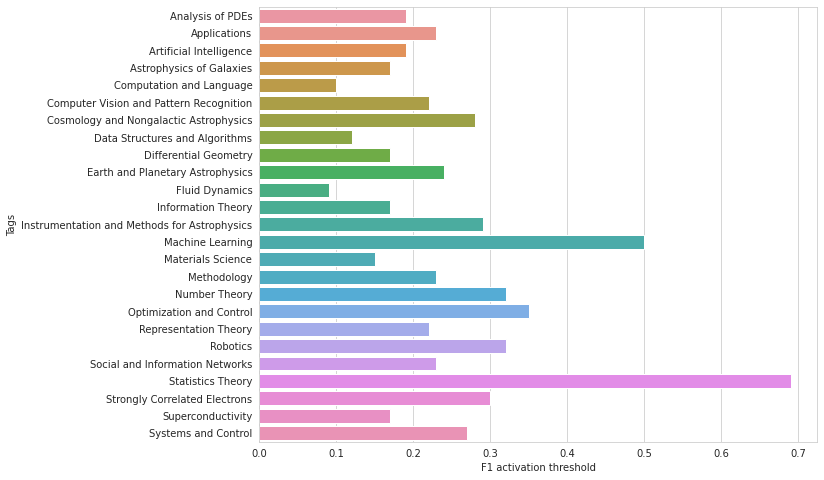

In [26]:
# plot best thresholds for each tag
plt.figure(figsize=(10, 8))
sns.barplot(best_thresholds, TARGET_COLS)
plt.xlabel('F1 activation threshold')
plt.ylabel('Tags');

In [27]:
# round predicted probabilities based on best F1 thresholds
for i, thresh in enumerate(best_thresholds):
  preds[:, i] = (preds[:, i] > thresh) * 1

preds

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [28]:
# create submission file
ss[TARGET_COLS] = preds.astype(np.int16)
ss.to_csv('submission_logreg_char_NB_opt.csv', index=False)

In [29]:
# and we're done!
'Done!'

'Done!'